In [2]:
# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')
# Library imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn")
from sklearn.svm import SVR
from sklearn import linear_model
import sklearn.metrics as metrics
from sklearn import preprocessing
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import make_scorer
from scipy.stats import chi2_contingency
from sklearn.linear_model import RidgeCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LassoLars
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import RFECV
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from scipy.spatial.distance import cdist, pdist
from sklearn.preprocessing import StandardScaler
pd.options.display.float_format = '{:.2f}'.format
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import GradientBoostingRegressor

### Pulmonary Fibrosis Progression Prediction via Machine Learning
This notebook documents our Occam's razor approach to predicting lung function decline using patients' medical history proxied by Forced Vital Capacity and Percent. New features are derived from provided 'training' data and run through Recursive Feature Elimination workflow.

### Import raw and formatted data

In [3]:
# import raw training data
train = pd.read_csv('train.csv')

In [4]:
train

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.25,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.71,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.86,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.95,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.06,79,Male,Ex-smoker
...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.59,73,Male,Never smoked
1545,ID00426637202313170790466,19,2978,73.13,73,Male,Never smoked
1546,ID00426637202313170790466,31,2908,71.41,73,Male,Never smoked
1547,ID00426637202313170790466,43,2975,73.05,73,Male,Never smoked


In [5]:
# import raw training data reshaped
train_reshaped = pd.read_csv('fvc_percent_history.csv')

### Reshape the raw data in 'long' format to wide format and create new features

In [6]:
features=train.groupby(['Patient','Sex', 'SmokingStatus'],as_index=False).agg(
    age=('Age', 'max'),
    min_week=('Weeks', 'min'),
    max_week=('Weeks', 'max'), 
    average_week=('Weeks', np.mean), 
    median_week=('Weeks', np.median),
    fvc_mean=('FVC', np.mean),
    fvc_median=('FVC', np.median),
    fvc_var=('FVC', 'var'),
    fvc_skew=('FVC', 'skew'),
    fvc_max=('FVC', 'max'),
    fvc_min=('FVC', 'min'),
    percent_mean=('Percent', np.mean),
    percent_median=('Percent', np.median),
    percent_var=('Percent', 'var'),
    percent_skew=('Percent', 'skew'),
    percent_max=('Percent', 'max'),
    percent_min=('Percent', 'min')
)

In [7]:
features

,Patient,Sex,SmokingStatus,age,min_week,max_week,average_week,median_week,fvc_mean,fvc_median,fvc_var,fvc_skew,fvc_max,fvc_min,percent_mean,percent_median,percent_var,percent_skew,percent_max,percent_min
0,ID00007637202177411956430,Male,Ex-smoker,79,-4,57,19.11,11.00,2113.89,2069.00,9381.11,1.26,2315,2000,53.19,52.06,5.94,1.26,58.25,50.33
1,ID00009637202177434476278,Male,Ex-smoker,69,8,60,24.00,15.00,3596.67,3625.00,38954.00,-0.70,3895,3214,83.81,84.47,21.15,-0.70,90.76,74.89
2,ID00010637202177584971671,Male,Ex-smoker,60,0,54,16.11,7.00,3037.11,3030.00,128474.86,-0.49,3523,2474,81.66,81.47,92.88,-0.49,94.72,66.52
3,ID00011637202177653955184,Male,Ex-smoker,72,6,58,22.00,13.00,3387.00,3410.00,12944.50,-0.36,3541,3193,87.56,88.16,8.65,-0.36,91.55,82.55
4,ID00012637202177665765362,Male,Never smoked,65,33,87,49.78,41.00,3348.78,3324.00,45127.44,0.25,3759,2971,91.83,91.15,33.93,0.25,103.08,81.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,ID00419637202311204720264,Male,Ex-smoker,73,6,59,21.78,13.00,2782.33,2738.00,10605.50,1.80,3020,2694,64.66,63.63,5.73,1.80,70.19,62.61
172,ID00421637202311550012437,Male,Ex-smoker,68,15,70,35.90,26.00,2759.00,2755.50,4356.89,-0.45,2853,2628,82.64,82.54,3.91,-0.45,85.46,78.72
173,ID00422637202311677017371,Male,Ex-smoker,73,6,47,20.88,16.00,1885.88,1913.50,6409.55,-1.66,1955,1713,74.92,76.02,10.12,-1.66,77.67,68.05
174,ID00423637202312137826377,Male,Ex-smoker,72,17,70,32.56,23.00,2750.00,2700.00,70378.75,1.11,3294,2432,66.17,64.97,40.75,1.11,79.26,58.52


In [8]:
features['range_week'] = features.max_week - features.min_week

In [9]:
features['percent_decline_rate'] = (features['percent_max'] - features['percent_min'])/features['range_week']

In [10]:
features['fvc_decline_rate'] = (features['fvc_max'] - features['fvc_min'])/features['range_week']

In [11]:
features.columns

Index(['Patient', 'Sex', 'SmokingStatus', 'age', 'min_week', 'max_week',
       'average_week', 'median_week', 'fvc_mean', 'fvc_median', 'fvc_var',
       'fvc_skew', 'fvc_max', 'fvc_min', 'percent_mean', 'percent_median',
       'percent_var', 'percent_skew', 'percent_max', 'percent_min',
       'range_week', 'percent_decline_rate', 'fvc_decline_rate'],
      dtype='object')

In [12]:
# merge derived features with reshaped raw training data
features_merged = pd.merge(features, train_reshaped, how='inner', on='Patient')

In [13]:
features_merged

,Patient,Sex,SmokingStatus,age,min_week,max_week,average_week,median_week,fvc_mean,fvc_median,...,percnt_2,percnt_3,percnt_4,percnt_5,percnt_6,percnt_7,percnt_8,percnt_9,visits,fvc_last
0,ID00007637202177411956430,Male,Ex-smoker,79,-4,57,19.11,11.00,2113.89,2069.00,...,55.71,51.86,53.95,52.06,52.87,50.33,51.94,51.76,9,2057.00
1,ID00009637202177434476278,Male,Ex-smoker,69,8,60,24.00,15.00,3596.67,3625.00,...,84.12,90.76,87.59,84.79,83.37,84.47,78.99,74.89,9,3214.00
2,ID00010637202177584971671,Male,Ex-smoker,60,0,54,16.11,7.00,3037.11,3030.00,...,90.69,89.45,80.47,81.47,83.43,80.47,66.52,67.70,9,2518.00
3,ID00011637202177653955184,Male,Ex-smoker,72,6,58,22.00,13.00,3387.00,3410.00,...,88.39,91.55,90.54,88.16,89.89,84.51,86.50,82.55,9,3193.00
4,ID00012637202177665765362,Male,Never smoked,65,33,87,49.78,41.00,3348.78,3324.00,...,103.08,89.83,94.41,89.61,94.58,91.15,88.60,81.47,9,2971.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,ID00419637202311204720264,Male,Ex-smoker,73,6,59,21.78,13.00,2782.33,2738.00,...,66.45,64.68,63.19,63.63,62.61,62.94,64.91,63.38,9,2727.00
172,ID00421637202311550012437,Male,Ex-smoker,68,15,70,35.90,26.00,2759.00,2755.50,...,82.55,82.52,84.47,85.46,81.36,84.86,83.00,160.17,9,2673.50
173,ID00422637202311677017371,Male,Ex-smoker,73,6,47,20.88,16.00,1885.88,1913.50,...,76.91,77.67,73.41,75.36,77.31,73.97,68.05,68.05,8,1713.00
174,ID00423637202312137826377,Male,Ex-smoker,72,17,70,32.56,23.00,2750.00,2700.00,...,66.82,64.97,72.52,64.03,66.84,60.54,58.52,62.03,9,2578.00


In [14]:
# merge features in long format
features_merged_long = pd.merge(features_merged, train, how='outer', on='Patient')

In [15]:
features_merged_long.columns

Index(['Patient', 'Sex_x', 'SmokingStatus_x', 'age', 'min_week', 'max_week',
       'average_week', 'median_week', 'fvc_mean', 'fvc_median', 'fvc_var',
       'fvc_skew', 'fvc_max', 'fvc_min', 'percent_mean', 'percent_median',
       'percent_var', 'percent_skew', 'percent_max', 'percent_min',
       'range_week', 'percent_decline_rate', 'fvc_decline_rate', 'fvc_1',
       'fvc_2', 'fvc_3', 'fvc_4', 'fvc_5', 'fvc_6', 'fvc_7', 'fvc_8', 'fvc_9',
       'percnt_1', 'percnt_2', 'percnt_3', 'percnt_4', 'percnt_5', 'percnt_6',
       'percnt_7', 'percnt_8', 'percnt_9', 'visits', 'fvc_last', 'Weeks',
       'FVC', 'Percent', 'Age', 'Sex_y', 'SmokingStatus_y'],
      dtype='object')

### Pre-process reshaped data for Feature Selection

In [16]:
y_train = features_merged_long['FVC']

In [17]:
# drop duplicate columns and pat
x_train = features_merged_long.drop(['FVC','Patient','SmokingStatus_y', 'Sex_y', 'age'], axis=1)

In [18]:
x_train.columns

Index(['Sex_x', 'SmokingStatus_x', 'min_week', 'max_week', 'average_week',
       'median_week', 'fvc_mean', 'fvc_median', 'fvc_var', 'fvc_skew',
       'fvc_max', 'fvc_min', 'percent_mean', 'percent_median', 'percent_var',
       'percent_skew', 'percent_max', 'percent_min', 'range_week',
       'percent_decline_rate', 'fvc_decline_rate', 'fvc_1', 'fvc_2', 'fvc_3',
       'fvc_4', 'fvc_5', 'fvc_6', 'fvc_7', 'fvc_8', 'fvc_9', 'percnt_1',
       'percnt_2', 'percnt_3', 'percnt_4', 'percnt_5', 'percnt_6', 'percnt_7',
       'percnt_8', 'percnt_9', 'visits', 'fvc_last', 'Weeks', 'Percent',
       'Age'],
      dtype='object')

In [19]:
x_train.shape

(1549, 44)

In [20]:
x_train[['Sex_x', 'SmokingStatus_x']] = x_train[['Sex_x', 'SmokingStatus_x']].astype('category')

In [21]:
x_train.rename(columns={"Sex_x": "Sex", "SmokingStatus_x": "SmokingStatus"}, inplace=True)

### Dummy-code categorical columns

In [22]:
dummies = pd.get_dummies(x_train[['Sex', 'SmokingStatus']], prefix='categorical')

In [23]:
dummies

,categorical_Female,categorical_Male,categorical_Currently smokes,categorical_Ex-smoker,categorical_Never smoked
0,0,1,0,1,0
1,0,1,0,1,0
2,0,1,0,1,0
3,0,1,0,1,0
4,0,1,0,1,0
...,...,...,...,...,...
1544,0,1,0,0,1
1545,0,1,0,0,1
1546,0,1,0,0,1
1547,0,1,0,0,1


In [24]:
X_train = x_train.drop(['Sex', 'SmokingStatus'], axis=1)

In [25]:
train_with_dummies = pd.concat([X_train, dummies], axis=1)

In [26]:
train_with_dummies

,min_week,max_week,average_week,median_week,fvc_mean,fvc_median,fvc_var,fvc_skew,fvc_max,fvc_min,...,visits,fvc_last,Weeks,Percent,Age,categorical_Female,categorical_Male,categorical_Currently smokes,categorical_Ex-smoker,categorical_Never smoked
0,-4,57,19.11,11.00,2113.89,2069.00,9381.11,1.26,2315,2000,...,9,2057.00,-4,58.25,79,0,1,0,1,0
1,-4,57,19.11,11.00,2113.89,2069.00,9381.11,1.26,2315,2000,...,9,2057.00,5,55.71,79,0,1,0,1,0
2,-4,57,19.11,11.00,2113.89,2069.00,9381.11,1.26,2315,2000,...,9,2057.00,7,51.86,79,0,1,0,1,0
3,-4,57,19.11,11.00,2113.89,2069.00,9381.11,1.26,2315,2000,...,9,2057.00,9,53.95,79,0,1,0,1,0
4,-4,57,19.11,11.00,2113.89,2069.00,9381.11,1.26,2315,2000,...,9,2057.00,11,52.06,79,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,0,59,21.33,13.00,2896.33,2916.00,8692.25,-1.29,2978,2712,...,9,2774.00,13,66.59,73,0,1,0,0,1
1545,0,59,21.33,13.00,2896.33,2916.00,8692.25,-1.29,2978,2712,...,9,2774.00,19,73.13,73,0,1,0,0,1
1546,0,59,21.33,13.00,2896.33,2916.00,8692.25,-1.29,2978,2712,...,9,2774.00,31,71.41,73,0,1,0,0,1
1547,0,59,21.33,13.00,2896.33,2916.00,8692.25,-1.29,2978,2712,...,9,2774.00,43,73.05,73,0,1,0,0,1


In [27]:
train_scaled = pd.DataFrame(preprocessing.scale(train_with_dummies))

### Feature Selection without scaling features

In [28]:
rf = RandomForestRegressor()

In [29]:
rfe_rf = RFE(rf, n_features_to_select=1)

In [30]:
rfe_rf.fit(train_with_dummies, y_train)

RFE(estimator=RandomForestRegressor(), n_features_to_select=1)

In [31]:
names = train_with_dummies.columns

In [32]:
print(sorted(zip(map(lambda x: round(x, 4), rfe_rf.ranking_), names)))

[(1, 'fvc_mean'), (2, 'fvc_median'), (3, 'fvc_max'), (4, 'fvc_5'), (5, 'Percent'), (6, 'fvc_4'), (7, 'fvc_8'), (8, 'fvc_6'), (9, 'fvc_last'), (10, 'fvc_3'), (11, 'fvc_7'), (12, 'Weeks'), (13, 'fvc_2'), (14, 'fvc_min'), (15, 'percnt_2'), (16, 'fvc_9'), (17, 'fvc_1'), (18, 'percnt_3'), (19, 'percent_min'), (20, 'percent_median'), (21, 'average_week'), (22, 'fvc_var'), (23, 'percnt_1'), (24, 'percent_max'), (25, 'percnt_6'), (26, 'percent_mean'), (27, 'percnt_5'), (28, 'percnt_4'), (29, 'percnt_8'), (30, 'percent_var'), (31, 'percnt_7'), (32, 'percnt_9'), (33, 'percent_decline_rate'), (34, 'fvc_skew'), (35, 'Age'), (36, 'percent_skew'), (37, 'fvc_decline_rate'), (38, 'range_week'), (39, 'median_week'), (40, 'max_week'), (41, 'min_week'), (42, 'categorical_Never smoked'), (43, 'visits'), (44, 'categorical_Ex-smoker'), (45, 'categorical_Currently smokes'), (46, 'categorical_Female'), (47, 'categorical_Male')]


### Feature Selection with Scaled Features

In [33]:
# scale features
train_scaled = pd.DataFrame(preprocessing.scale(train_with_dummies), columns=names)

In [34]:
train_scaled

,min_week,max_week,average_week,median_week,fvc_mean,fvc_median,fvc_var,fvc_skew,fvc_max,fvc_min,...,visits,fvc_last,Weeks,Percent,Age,categorical_Female,categorical_Male,categorical_Currently smokes,categorical_Ex-smoker,categorical_Never smoked
0,-1.20,-0.61,-0.82,-0.83,-0.71,-0.78,-0.50,1.58,-0.69,-0.54,...,0.31,-0.59,-1.54,-0.98,1.67,-0.52,0.52,-0.24,0.70,-0.62
1,-1.20,-0.61,-0.82,-0.83,-0.71,-0.78,-0.50,1.58,-0.69,-0.54,...,0.31,-0.59,-1.16,-1.11,1.67,-0.52,0.52,-0.24,0.70,-0.62
2,-1.20,-0.61,-0.82,-0.83,-0.71,-0.78,-0.50,1.58,-0.69,-0.54,...,0.31,-0.59,-1.07,-1.30,1.67,-0.52,0.52,-0.24,0.70,-0.62
3,-1.20,-0.61,-0.82,-0.83,-0.71,-0.78,-0.50,1.58,-0.69,-0.54,...,0.31,-0.59,-0.98,-1.20,1.67,-0.52,0.52,-0.24,0.70,-0.62
4,-1.20,-0.61,-0.82,-0.83,-0.71,-0.78,-0.50,1.58,-0.69,-0.54,...,0.31,-0.59,-0.90,-1.29,1.67,-0.52,0.52,-0.24,0.70,-0.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,-0.94,-0.50,-0.68,-0.70,0.25,0.26,-0.52,-0.95,0.09,0.36,...,0.31,0.27,-0.81,-0.56,0.82,-0.52,0.52,-0.24,-1.43,1.62
1545,-0.94,-0.50,-0.68,-0.70,0.25,0.26,-0.52,-0.95,0.09,0.36,...,0.31,0.27,-0.55,-0.23,0.82,-0.52,0.52,-0.24,-1.43,1.62
1546,-0.94,-0.50,-0.68,-0.70,0.25,0.26,-0.52,-0.95,0.09,0.36,...,0.31,0.27,-0.04,-0.32,0.82,-0.52,0.52,-0.24,-1.43,1.62
1547,-0.94,-0.50,-0.68,-0.70,0.25,0.26,-0.52,-0.95,0.09,0.36,...,0.31,0.27,0.48,-0.23,0.82,-0.52,0.52,-0.24,-1.43,1.62


### LASSO Regression for Feature Selection

In [35]:
lasso_reg = linear_model.Lasso(alpha=0.1)

In [36]:
lasso_reg.fit(train_scaled, y_train)

Lasso(alpha=0.1)

In [37]:
importance = np.abs(lasso_reg.coef_)

In [38]:
print(sorted(zip(map(lambda x: round(x, 4), importance), names),reverse=True))

[(655.2949, 'Percent'), (504.9051, 'fvc_mean'), (393.509, 'percent_mean'), (153.6318, 'fvc_2'), (120.6063, 'percnt_2'), (59.2755, 'fvc_3'), (42.0729, 'percnt_3'), (37.6268, 'fvc_4'), (32.5131, 'percnt_4'), (16.9691, 'fvc_min'), (13.2254, 'percent_min'), (11.3384, 'fvc_6'), (9.9164, 'percnt_6'), (9.4197, 'fvc_last'), (8.2552, 'fvc_max'), (7.6911, 'percent_max'), (5.1127, 'fvc_7'), (4.2417, 'percnt_5'), (3.5895, 'fvc_median'), (3.2139, 'percnt_8'), (2.7388, 'Weeks'), (1.6581, 'percnt_7'), (1.2391, 'percnt_9'), (1.1944, 'average_week'), (1.1355, 'fvc_8'), (0.7692, 'min_week'), (0.7113, 'percnt_1'), (0.6523, 'categorical_Currently smokes'), (0.5179, 'percent_var'), (0.4869, 'fvc_9'), (0.3981, 'visits'), (0.1976, 'categorical_Female'), (0.1308, 'categorical_Ex-smoker'), (0.1085, 'max_week'), (0.0594, 'fvc_5'), (0.047, 'fvc_skew'), (0.0, 'range_week'), (0.0, 'percent_skew'), (0.0, 'percent_median'), (0.0, 'percent_decline_rate'), (0.0, 'median_week'), (0.0, 'fvc_var'), (0.0, 'fvc_decline_rat

#### Drop features with zero weight

In [39]:
x_train_nonzeroweights = train_scaled.drop(['range_week', 'percent_skew', 'percent_median', 'percent_decline_rate',\
                        'median_week', 'fvc_var', 'fvc_decline_rate', 'categorical_Never smoked',\
                        'categorical_Male', 'Age'], axis=1)

## Patient Segmentation

In [40]:
kmeans = KMeans(n_clusters=3, random_state=0)

In [41]:
X = x_train_nonzeroweights

In [42]:
kmeans.fit(X)

KMeans(n_clusters=3, random_state=0)

In [43]:
y_kmeans = kmeans.predict(X)

Text(0.5, 1.0, 'Elbow Chart for KMeans clustering')

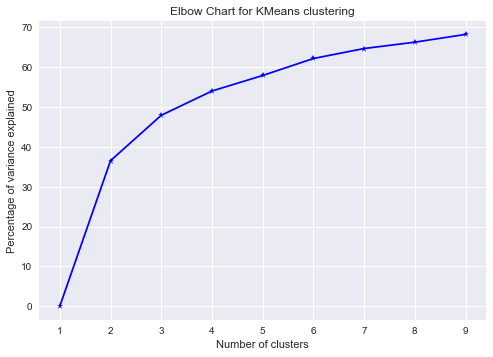

In [44]:
K = range(1,10)
KM = [KMeans(n_clusters=k).fit(X) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(D,axis=1) for D in D_k]

wcss = [sum(d**2) for d in dist]
tss = sum(pdist(X)**2)/X.shape[0]
bss = tss-wcss

kIdx = 10-1

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, bss/tss*100, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of variance explained')
plt.title('Elbow Chart for KMeans clustering')

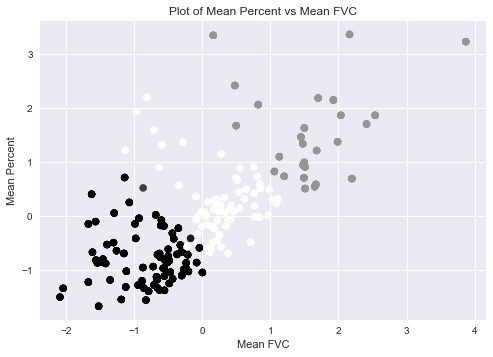

In [45]:
plt.scatter(x_train_nonzeroweights['fvc_mean'], x_train_nonzeroweights['percent_mean'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.xlabel('Mean FVC')
plt.ylabel('Mean Percent')
plt.title('Plot of Mean Percent vs Mean FVC')
plt.show();

## Regression Models for Prediction of Forced Vital Capacity (FVC)

In [46]:
# split dataset into traning and test set for binary classification
X_Train, X_Test, Y_Train, Y_test = train_test_split(x_train_nonzeroweights, y_train, test_size = 0.3)

### Model Comparison (MAPE)

In [47]:
def MAPE_error(model, X_Test, Y_test):
    y_pred = model.predict(X_Test)
    return np.mean(np.abs((Y_test - y_pred) / Y_test)) * 100,\
           model.__class__.__name__

if __name__ == "__main__":
    regressors = [LinearRegression(), BayesianRidge(), Ridge(alpha=.5, random_state=0),
                  Lasso(alpha=0.1, random_state=0), LassoLars(), KNeighborsRegressor(),
                  ARDRegression(), RandomForestRegressor(random_state=0, n_estimators=100),
                  SVR(gamma='scale', kernel='linear'),
                  RidgeCV(fit_intercept=False), ElasticNet(random_state=0),
                  DecisionTreeRegressor(random_state=0), AdaBoostRegressor(random_state=0),
                  GradientBoostingRegressor(random_state=0)]
    for reg in regressors:
        reg.fit(X_Train, Y_Train)
        MAPE, name = MAPE_error(reg, X_Test, Y_test)
        name = reg.__class__.__name__
        print(name + ' Mean Absolute Percentage Error:', end=' ')
        print(np.round((MAPE), 4)) 
print(" ")
print("3-fold Cross Validation:")  
for reg in regressors:
    cv_results = cross_validate(reg, X_Train, Y_Train, cv=3, return_train_score=True)
    name = reg.__class__.__name__
    print(name + ' MAPE:', end=' ')
    print('train: ', np.round(cv_results['train_score'], 4), 'test :', np.round(cv_results['test_score'], 4) ) 

LinearRegression Mean Absolute Percentage Error: 1.0417
BayesianRidge Mean Absolute Percentage Error: 1.0543
Ridge Mean Absolute Percentage Error: 1.0524
Lasso Mean Absolute Percentage Error: 1.0151
LassoLars Mean Absolute Percentage Error: 4.7557
KNeighborsRegressor Mean Absolute Percentage Error: 5.0509
ARDRegression Mean Absolute Percentage Error: 0.9916
RandomForestRegressor Mean Absolute Percentage Error: 2.8155
SVR Mean Absolute Percentage Error: 3.3097
RidgeCV Mean Absolute Percentage Error: 112.4791
ElasticNet Mean Absolute Percentage Error: 4.4943
DecisionTreeRegressor Mean Absolute Percentage Error: 3.1839
AdaBoostRegressor Mean Absolute Percentage Error: 5.2627
GradientBoostingRegressor Mean Absolute Percentage Error: 2.7864
 
3-fold Cross Validation:
LinearRegression MAPE: train:  [0.998  0.9978 0.9984] test : [0.9977 0.9981 0.9967]
BayesianRidge MAPE: train:  [0.998  0.9978 0.9983] test : [0.9979 0.9981 0.9968]
Ridge MAPE: train:  [0.9979 0.9978 0.9983] test : [0.9979 0.99